In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import holidays
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import xgboost
from prophet import Prophet

from sklearn.metrics import mean_squared_error,mean_absolute_error
from math import sqrt

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore",FutureWarning)

In [63]:
df=pd.read_csv('PJME_hourly.csv')
df.count()
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [64]:
#Data preprocessing

df=df.set_index("Datetime")
df.index=pd.to_datetime(df.index)
df=df.sort_index()
df.head()

,PJME_MW
Datetime,
2002-01-01 01:00:00,30393.0
2002-01-01 02:00:00,29265.0
2002-01-01 03:00:00,28357.0
2002-01-01 04:00:00,27899.0
2002-01-01 05:00:00,28057.0


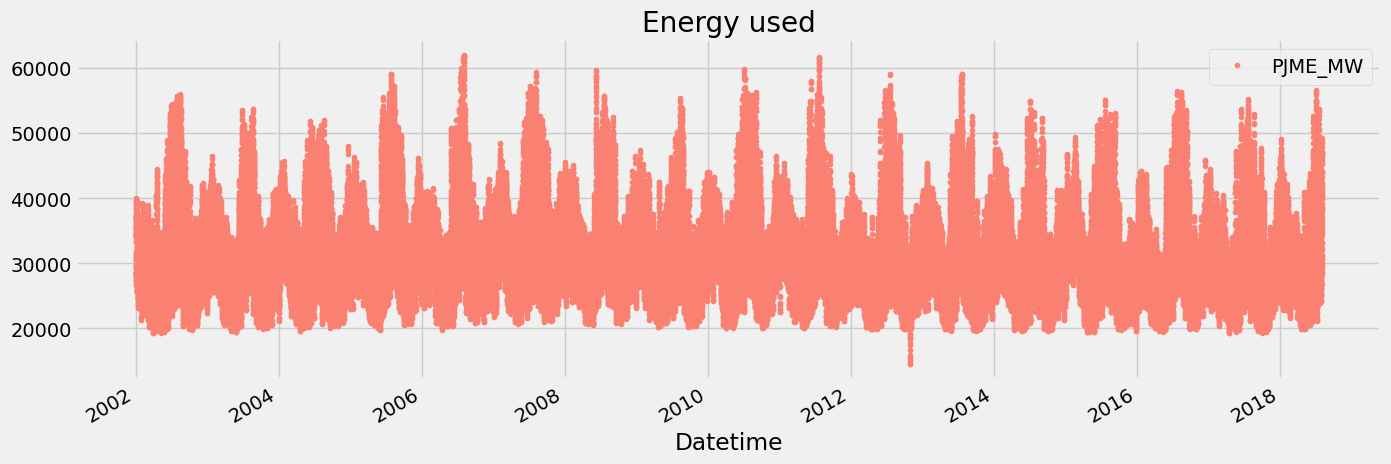

In [65]:
#Exploratary data analysis


plt.style.use("fivethirtyeight")

# dataset image plot
df.plot(
    style=".",
    figsize=(15,5),
    color="salmon",
    title="Energy used"
)
plt.show()

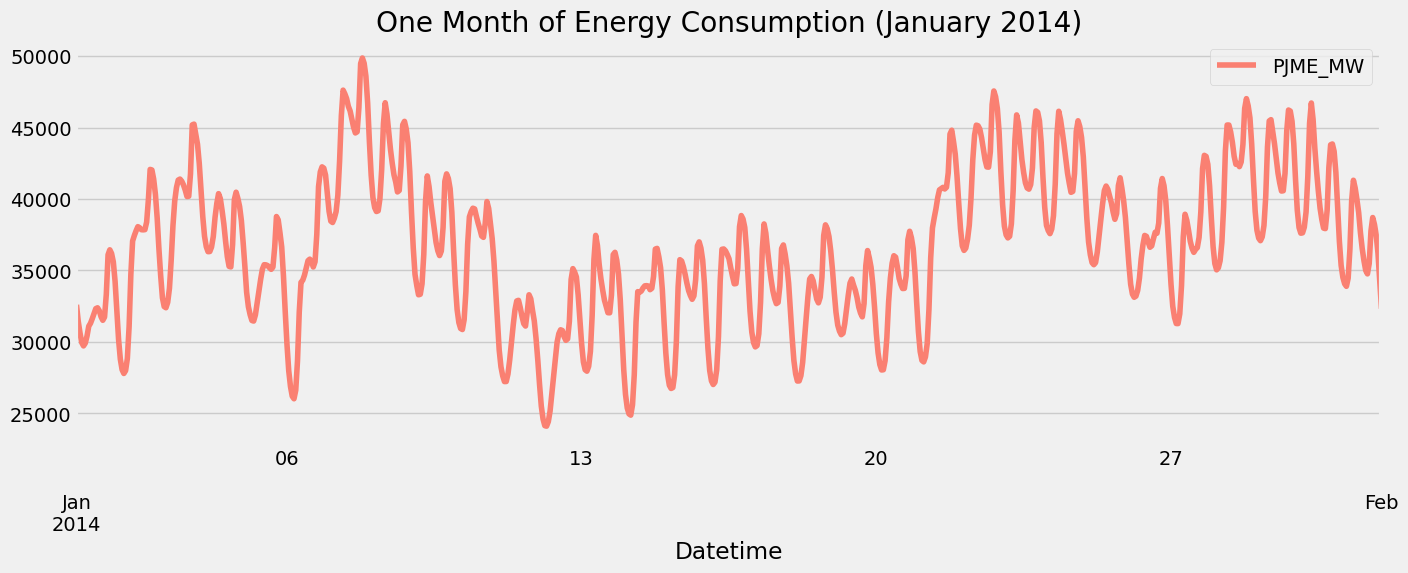

In [66]:
#Monthly analysis

#Get for a month
one_month=df.loc[(df.index >="2014-01-01") & (df.index <="2014-02-01")]

#Plot
one_month.plot(
    style="-",
    figsize=(15,5),
    color="salmon",
    title="One Month of Energy Consumption (January 2014)"
)
plt.show()

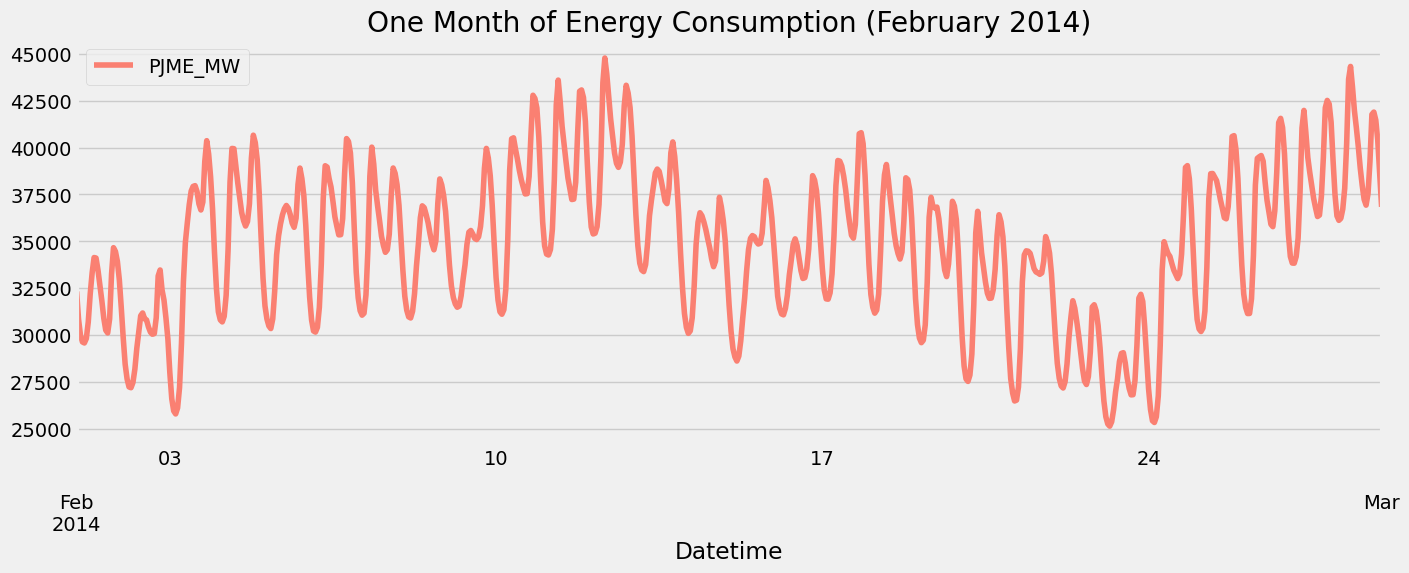

In [67]:
one_month=df.loc[(df.index >="2014-02-01") & (df.index <="2014-03-01")]

#Plot
one_month.plot(
    style="-",
    figsize=(15,5),
    color="salmon",
    title="One Month of Energy Consumption (February 2014)"
)
plt.show()

The energy consumption of each month does not appear to be consistent.

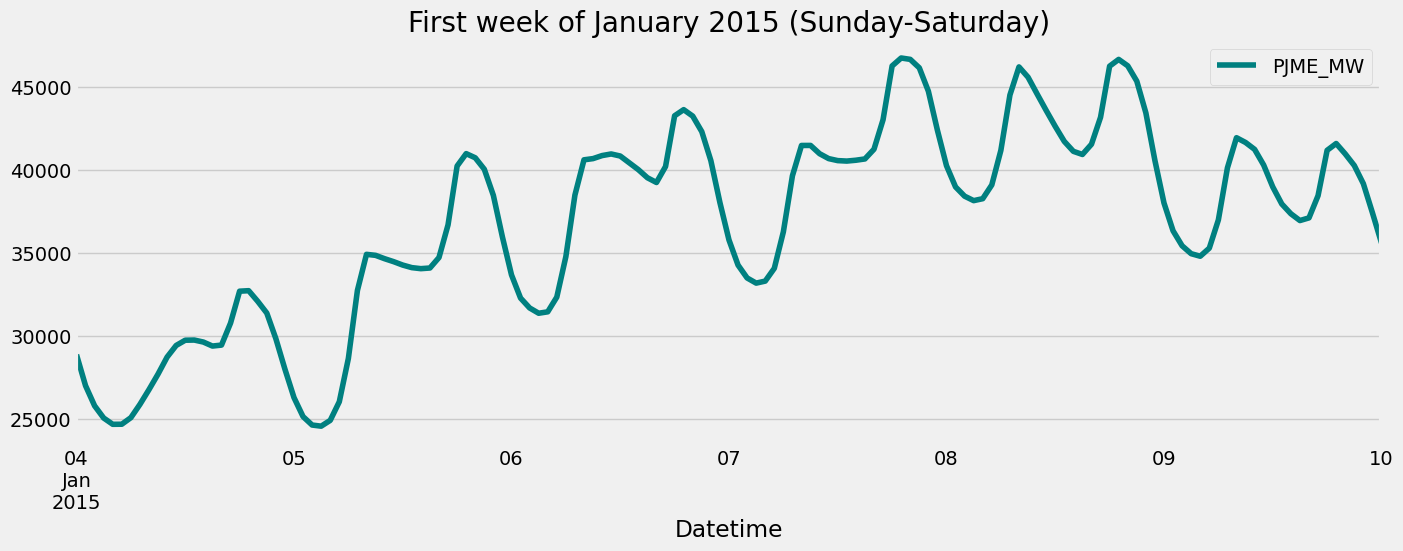

In [68]:
#Weekly analysis

#Get for a week
one_week=df.loc[(df.index >='2015-01-04') & (df.index <='2015-01-10')]

#Plot
one_week.plot(
    figsize=(15,5),
    title="First week of January 2015 (Sunday-Saturday)",
    color='teal'
)
plt.show()

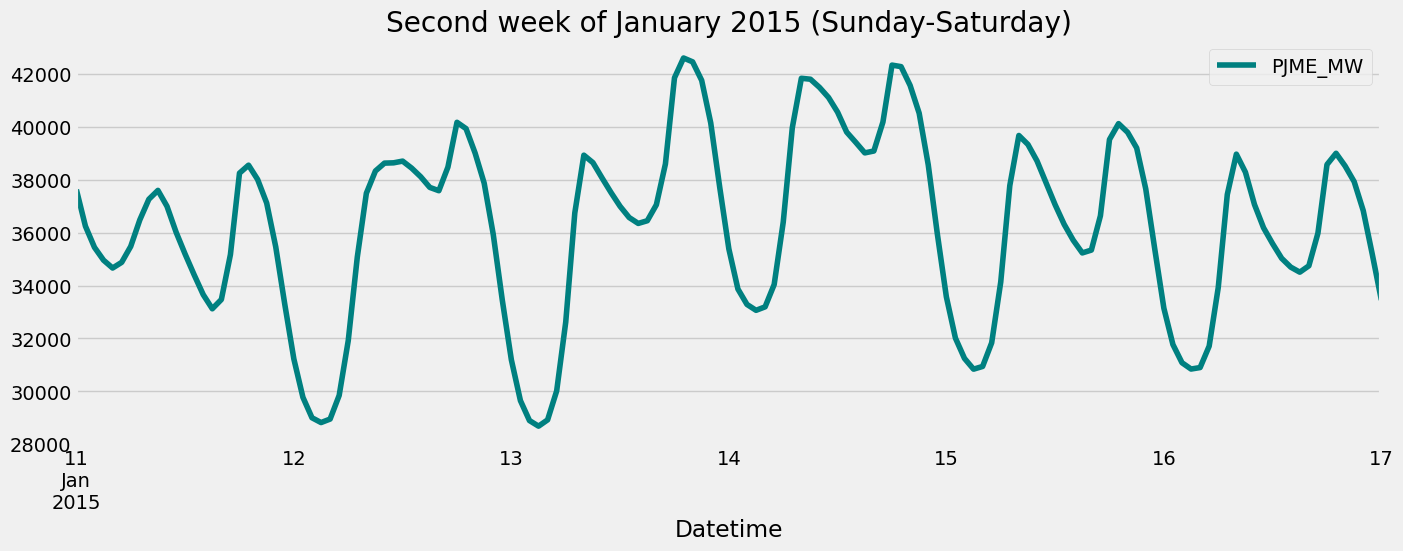

In [69]:
#Let's see in week two
one_week=df.loc[(df.index >='2015-01-11') & (df.index <='2015-01-17')]

#Plot
one_week.plot(
    figsize=(15,5),
    title="Second week of January 2015 (Sunday-Saturday)",
    color='teal'
)
plt.show()

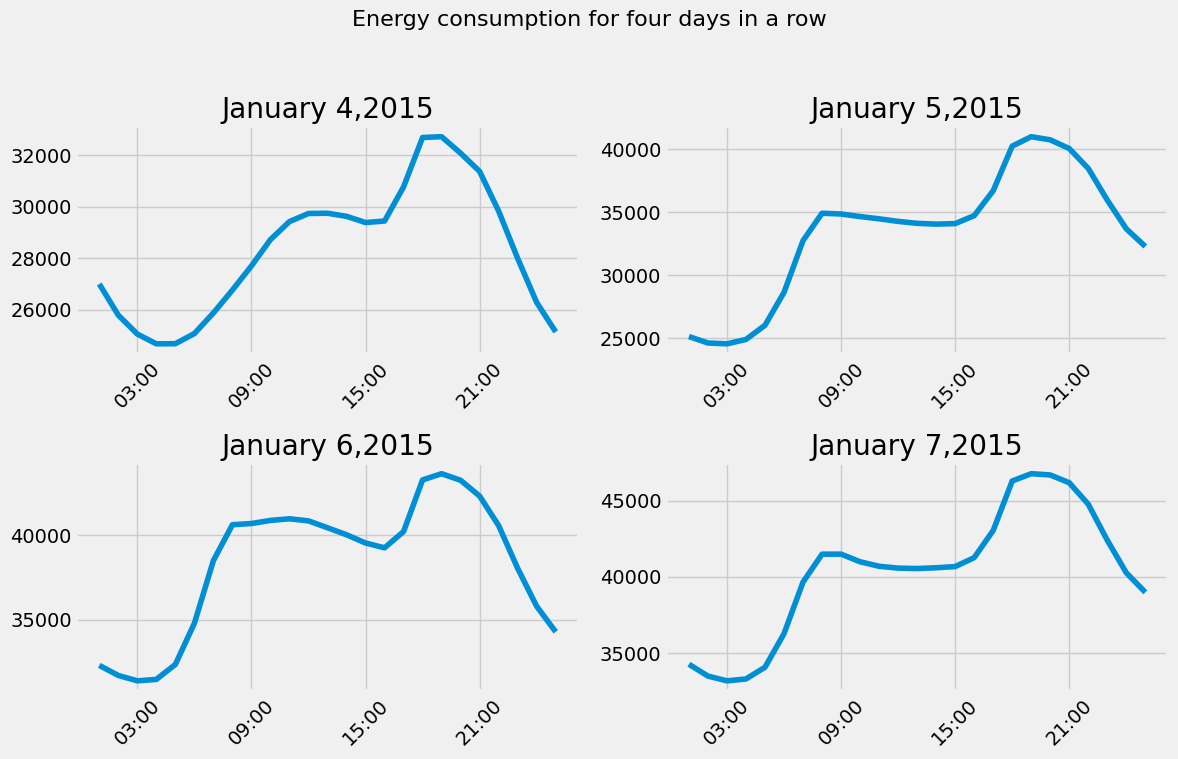

In [70]:
#Get for a day
day_one=df.loc[(df.index >='2015-01-04 01:00:00') & (df.index <='2015-01-05 01:00:00')]
day_two=df.loc[(df.index >='2015-01-05 01:00:00') & (df.index <='2015-01-06 01:00:00')]
day_three=df.loc[(df.index >='2015-01-06 01:00:00') & (df.index <='2015-01-07 01:00:00')]
day_four=df.loc[(df.index >='2015-01-07 01:00:00') & (df.index <='2015-01-08 01:00:00')]

days=[day_one,day_two,day_three,day_four]
day_labels=['January 4,2015','January 5,2015','January 6,2015','January 7,2015']

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(12,8))
fig.suptitle('Energy consumption for four days in a row',fontsize=16)

axes=axes.flatten()

for i,day in enumerate(days):
    axes[i].plot(day.index,day['PJME_MW'])
    axes[i].set_title(day_labels[i])
    
    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=6))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    axes[i].tick_params(axis='x',rotation=45)

plt.tight_layout(rect=[0,0.03,1,0.95])
plt.show()

In [71]:
#Data splitting into train and test data set
def split_data(df,date="01-01-2015"):
    train=df.iloc[df.index < date]
    test=df.iloc[df.index >=date]
    return train,test

In [72]:
train,test=split_data(df)

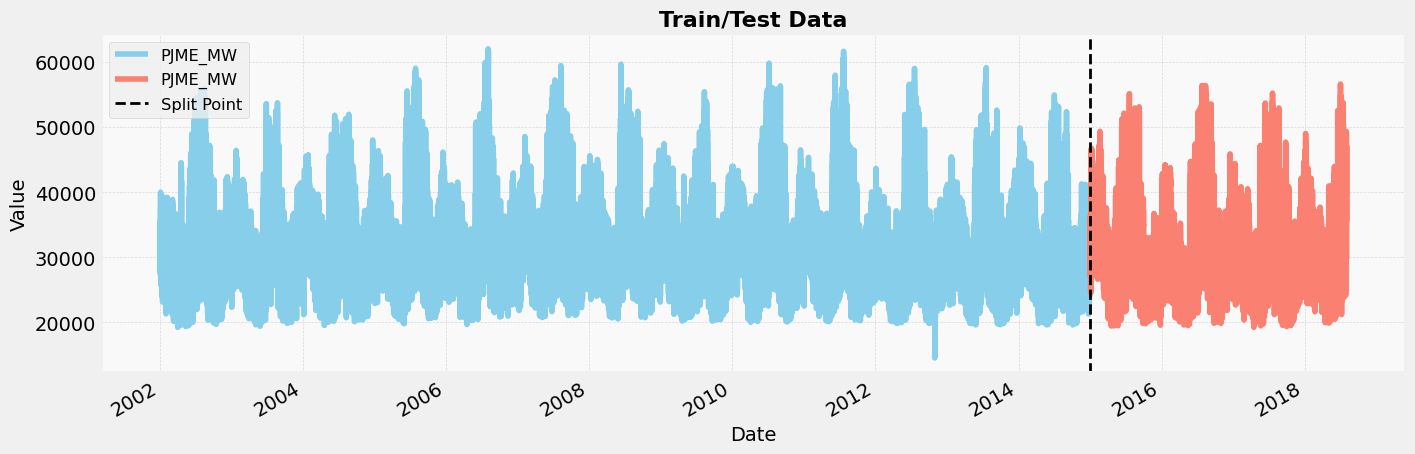

In [73]:
#Visualization of train and test data
fig,ax=plt.subplots(figsize=(15,5))

train.plot(ax=ax,color="skyblue",label="Train Set")
test.plot(ax=ax,color="salmon",label="Test Set")

ax.axvline(pd.to_datetime("01-01-2015"),color="black",ls="--",lw=2,label="Split Point")

ax.set_title("Train/Test Data",fontsize=16,fontweight="bold")
ax.set_xlabel("Date",fontsize=14)
ax.set_ylabel("Value",fontsize=14)
ax.legend(fontsize="small",loc="upper left")
plt.grid(True,linestyle="--",linewidth=.5,alpha=.7)
ax.set_facecolor("#F9F9F9")

plt.show()

In [74]:
#Feature selection

def create_features(df):
    df=df.copy()
    df["hour"]=df.index.hour
    df["dayofweek"]=df.index.dayofweek
    df["quarter"]=df.index.quarter
    df["month"]=df.index.month
    df["year"]=df.index.year
    df["dayofyear"]=df.index.dayofyear
    df["dayofmonth"]=df.index.day
    df["weekofyear"]=df.index.isocalendar().week
    return add_holidays(df)

def add_holidays(df,country="US"):
    df=df.copy()
    holiday_list=holidays.CountryHoliday(country)
    
    # make a column with "0" for workdays and "1" for offdays
    df["holiday"]=df.index.map(lambda x: x in holiday_list).astype(int)
    return df

df_original=df.copy()
df=create_features(df)
df=add_holidays(df)

In [75]:
natal=df.loc[df.index =="2015-12-25"]
tahun_baru=df.loc[df.index =="2016-01-01"]
random_day=df.loc[df.index =="2016-01-02"]

print("Christmas",natal["holiday"])
print("New Year",tahun_baru["holiday"])
print("Non-holiday",random_day["holiday"])

Christmas Datetime
2015-12-25    1
Name: holiday, dtype: int32
New Year Datetime
2016-01-01    1
Name: holiday, dtype: int32
Non-holiday Datetime
2016-01-02    0
Name: holiday, dtype: int32


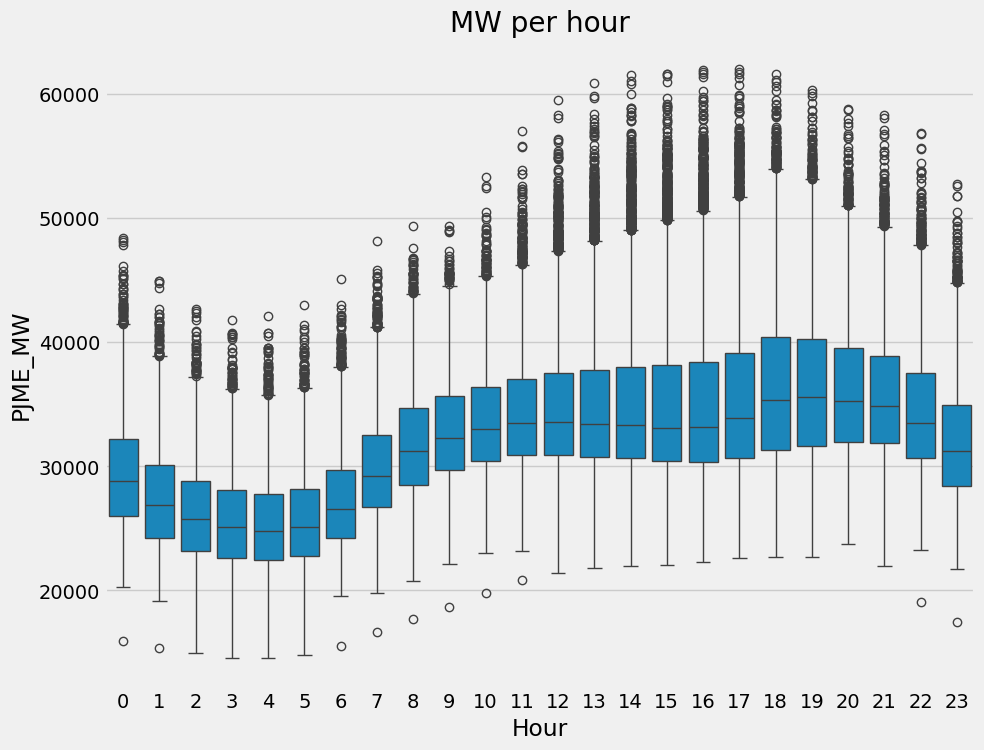

In [76]:
#Distribution for every hour per day
fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x="hour",y="PJME_MW")
ax.set_title("MW per hour")
ax.set_xlabel("Hour")
plt.show()

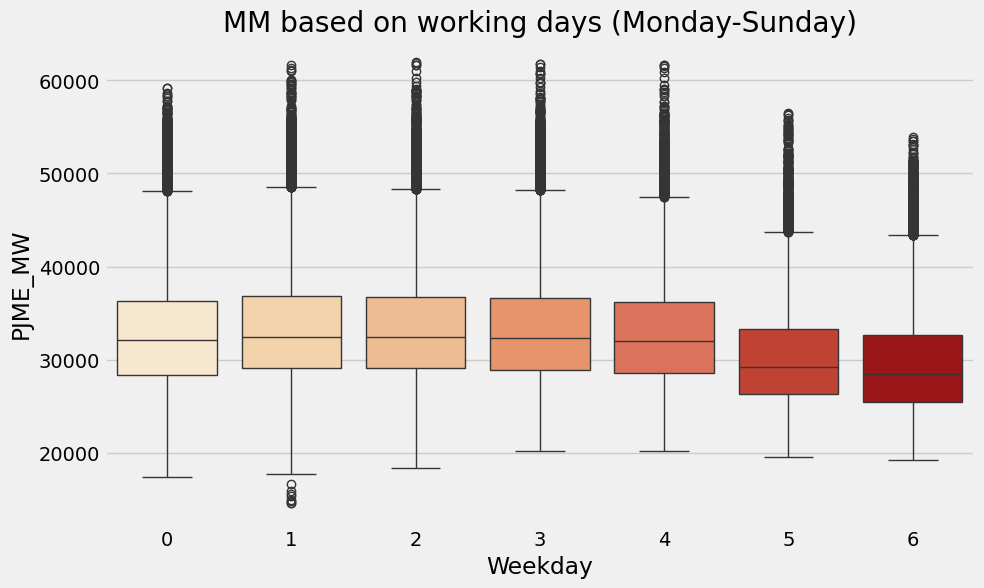

In [77]:
#Daily distribution based on a week

fig,ax=plt.subplots(figsize=(10,6))
sns.boxplot(data=df,x="dayofweek",y="PJME_MW",palette="OrRd")
ax.set_xlabel("Weekday")
ax.set_title("MM based on working days (Monday-Sunday)")
plt.show()

Weekends have much lower energy consumption. This is due to the shutdown of large business buildings,which require more power to operate than residential homes.

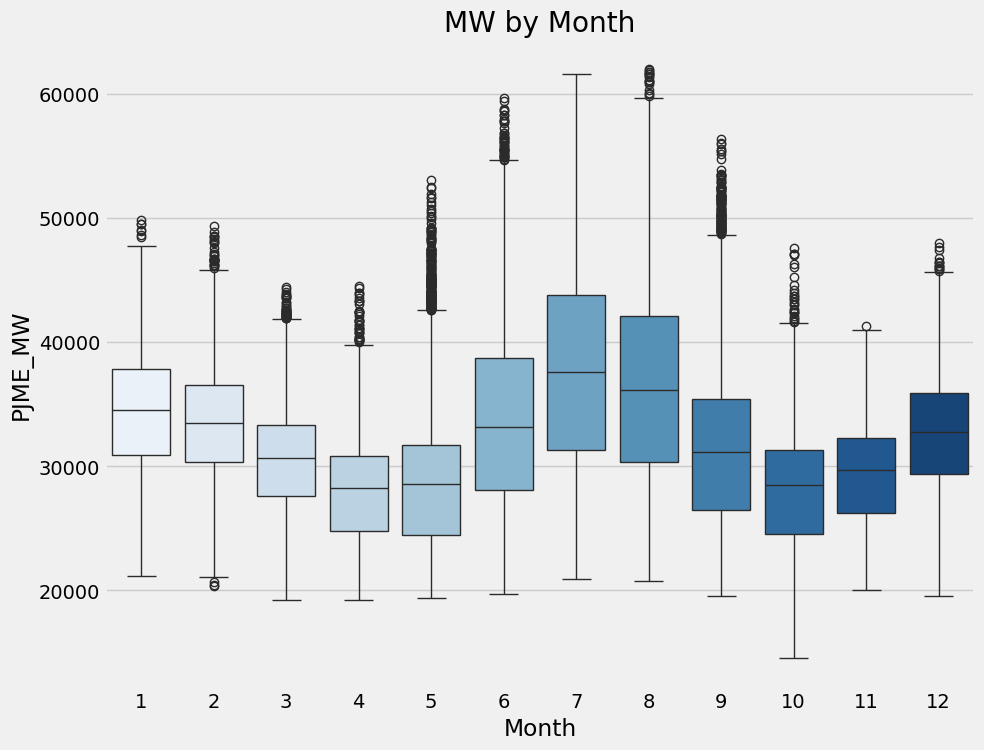

In [78]:
#Distribution every month

fig,ax=plt.subplots(figsize=(10,8))
sns.boxplot(data=df,x="month",y="PJME_MW",palette="Blues")
ax.set_title("MW by Month")
ax.set_xlabel("Month")
plt.show()

There are seasonal effects that may be produced by more intense weather during winter or summer,resulting in more energy being consumed for heating and air conditioning.

In [79]:
#Preparing datasets

train=create_features(train)
test=create_features(test)

FEATURES=['hour','dayofweek','month','year','weekofyear','dayofmonth','dayofyear','quarter'] 
TARGET='PJME_MW'

X_train=train[FEATURES]
y_train=train[TARGET]

X_test=test[FEATURES]
y_test=test[TARGET]

In [80]:
#Using XGBoost

reg=xgboost.XGBRegressor(
    base_score=.5,booster="gbtree",
    n_estimators=1300,
    early_stopping_rounds=50,
    objective="reg:squarederror",
    max_depth=3,
    learning_rate=.01,
)

reg.fit(
    X_train,y_train,
    eval_set=[(X_train,y_train),(X_test,y_test)],
    verbose=100,
)

#Verbose 100 shows the MSE score every 100 iterations
#Model training iteration will stop when the RMSE score is low

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729
[100]	validation_0-rmse:12584.35120	validation_1-rmse:11747.05819
[200]	validation_0-rmse:5836.44568	validation_1-rmse:5362.84878
[300]	validation_0-rmse:3921.88439	validation_1-rmse:4003.42883
[400]	validation_0-rmse:3446.55147	validation_1-rmse:3849.33216
[500]	validation_0-rmse:3286.83297	validation_1-rmse:3813.39212
[600]	validation_0-rmse:3202.19463	validation_1-rmse:3781.93118
[700]	validation_0-rmse:3146.56966	validation_1-rmse:3768.42786
[800]	validation_0-rmse:3107.49011	validation_1-rmse:3752.56429
[900]	validation_0-rmse:3075.84491	validation_1-rmse:3743.15767
[1000]	validation_0-rmse:3047.80328	validation_1-rmse:3731.96038
[1100]	validation_0-rmse:3023.42293	validation_1-rmse:3722.65763
[1200]	validation_0-rmse:3002.44044	validation_1-rmse:3716.01927
[1299]	validation_0-rmse:2981.51192	validation_1-rmse:3707.92141


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1300, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

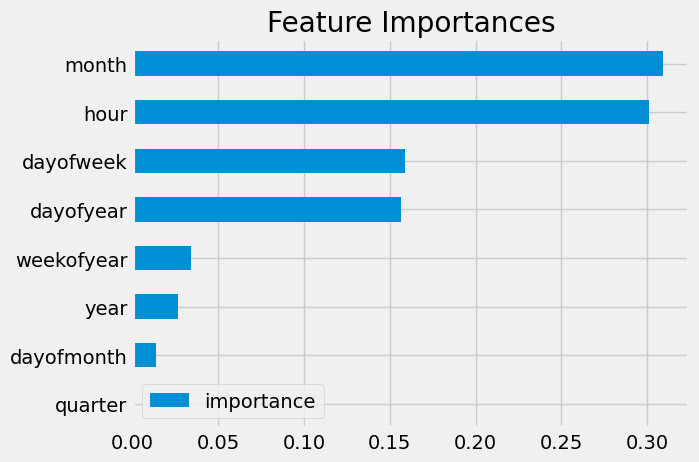

In [81]:
#Plotting Feature Importances


fi=pd.DataFrame(
    data=reg.feature_importances_,
    index=reg.feature_names_in_,
    columns=["importance"]
)

fi.sort_values("importance").plot(kind="barh",title="Feature Importances")
plt.show()

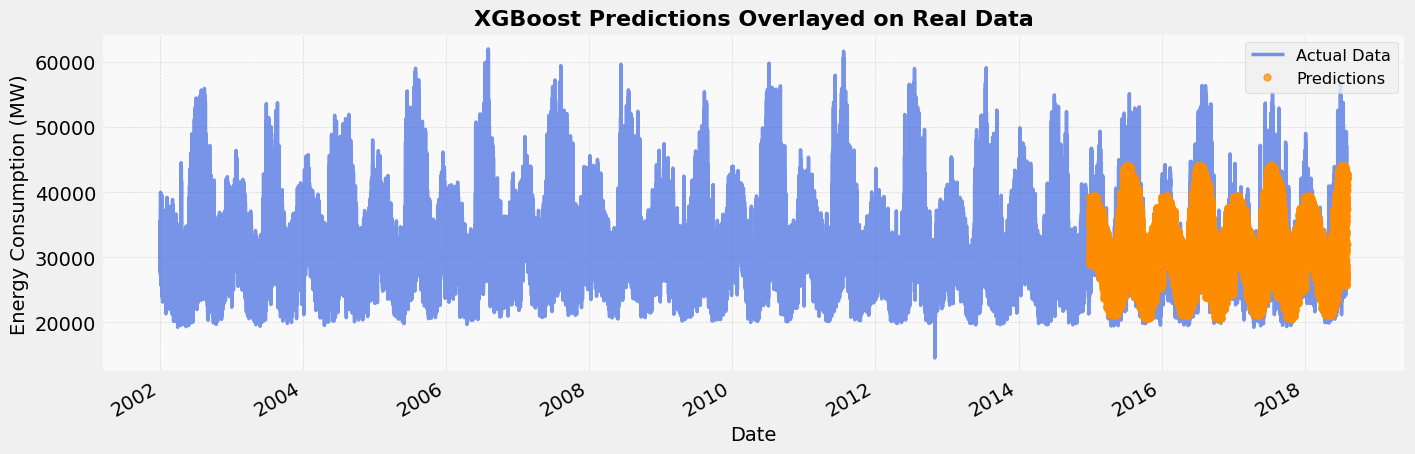

In [82]:
test['prediction']=reg.predict(X_test)
df=df.merge(test[['prediction']],how='left',left_index=True,right_index=True)

# plot original data
ax=df[['PJME_MW']].plot(figsize=(15,5),linewidth=2.5,linestyle='-',color='royalblue',alpha=0.7)

# plot prediction
df['prediction'].plot(ax=ax,style='o',markersize=5,color='darkorange',alpha=0.7)

plt.legend(['Actual Data','Predictions'],fontsize='small')
ax.set_title('XGBoost Predictions Overlayed on Real Data',fontsize=16,fontweight='bold')
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Energy Consumption (MW)',fontsize=14)
plt.grid(True,linestyle='--',linewidth=0.5,alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area

plt.show()

In [83]:
#Function for mape

#Error metrics


def mape(y_true,y_pred):
    y_true,y_pred=np.array(y_true),np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
mae_score=mean_absolute_error(test['PJME_MW'],test['prediction'])
print(f'Mean Absolute Error Score : {mae_score:0.2f}')

Mean Absolute Error Score : 2858.33


In [85]:
rmse_score=sqrt(mean_squared_error(test['PJME_MW'],test['prediction']))
print(f'RMSE Score : {rmse_score:0.2f}')

RMSE Score : 3706.97


In [86]:
mape_score=mape(test['PJME_MW'],test['prediction'])
print(f'Mean Absolute Percentage Error Score : {mape_score:0.2f}')

Mean Absolute Percentage Error Score : 8.99


In [87]:
#Reset dataframe
df=df_original.copy()
train,test=split_data(df)

In [88]:
#Data format for Prophet models using ds and y
prophet_train=train.reset_index() \
    .rename(columns={'Datetime':'ds','PJME_MW':'y'})
prophet_train.head()

,ds,y
0,2002-01-01 01:00:00,30393.0
1,2002-01-01 02:00:00,29265.0
2,2002-01-01 03:00:00,28357.0
3,2002-01-01 04:00:00,27899.0
4,2002-01-01 05:00:00,28057.0


In [89]:
cal=calendar()

df['date']=df.index.date
df['is_holiday']=df.date.isin([d.date() for d in cal.holidays()])
holiday_df=df.loc[df['is_holiday']] \
    .reset_index() \
    .rename(columns={'Datetime':'ds'})
holiday_df['holiday']='USFederalHoliday'
holiday_df=holiday_df.drop(['PJME_MW','date','is_holiday'],axis=1)
holiday_df.head()

,ds,holiday
0,2002-01-01 01:00:00,USFederalHoliday
1,2002-01-01 02:00:00,USFederalHoliday
2,2002-01-01 03:00:00,USFederalHoliday
3,2002-01-01 04:00:00,USFederalHoliday
4,2002-01-01 05:00:00,USFederalHoliday


In [90]:
holiday_df['ds']=pd.to_datetime(holiday_df['ds'])

In [91]:
prophet_model=Prophet(holidays=holiday_df)
prophet_model.fit(prophet_train)

21:34:53 - cmdstanpy - INFO - Chain [1] start processing
21:37:16 - cmdstanpy - INFO - Chain [1] done processing


In [92]:
#Predict
prophet_fcst=prophet_model.predict(df=test.reset_index() \
                                   .rename(columns={'Datetime':'ds'}))

In [58]:
prophet_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,USFederalHoliday,USFederalHoliday_lower,USFederalHoliday_upper,additive_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 00:00:00,31243.327467,24081.369571,33204.034848,31243.327467,31243.327467,-1839.571396,-1839.571396,-1839.571396,-2460.166344,...,1298.693553,1298.693553,1298.693553,493.165257,493.165257,493.165257,0.0,0.0,0.0,28783.161123
1,2015-01-01 01:00:00,31243.287864,22356.921326,30968.896371,31243.287864,31243.287864,-1839.571396,-1839.571396,-1839.571396,-4483.125219,...,1292.590533,1292.590533,1292.590533,494.475099,494.475099,494.475099,0.0,0.0,0.0,26760.162646
2,2015-01-01 02:00:00,31243.248261,20743.131230,29843.133295,31243.248261,31243.248261,-1839.571396,-1839.571396,-1839.571396,-5986.327643,...,1284.812450,1284.812450,1284.812450,495.822587,495.822587,495.822587,0.0,0.0,0.0,25256.920619
3,2015-01-01 03:00:00,31243.208658,20088.842160,28731.595743,31243.208658,31243.208658,-1839.571396,-1839.571396,-1839.571396,-6857.228090,...,1275.472275,1275.472275,1275.472275,497.207749,497.207749,497.207749,0.0,0.0,0.0,24385.980569
4,2015-01-01 04:00:00,31243.169055,19666.045691,28599.522410,31243.169055,31243.169055,-1839.571396,-1839.571396,-1839.571396,-6998.426744,...,1264.703135,1264.703135,1264.703135,498.630614,498.630614,498.630614,0.0,0.0,0.0,24244.742311


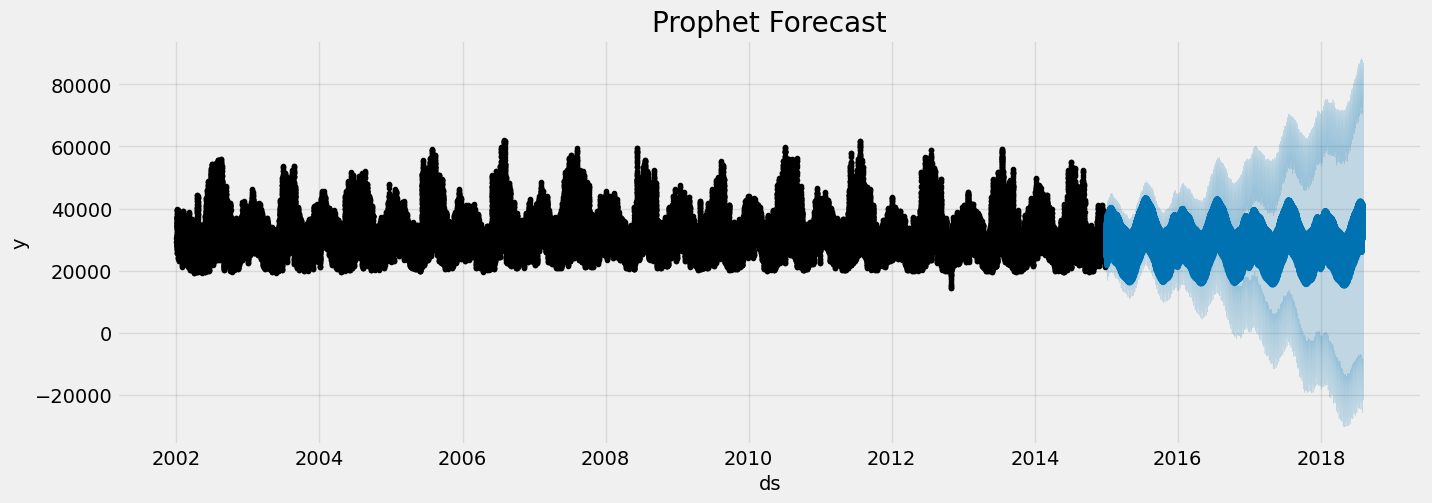

In [93]:
#Plot prediction result
f,ax=plt.subplots(1)
ax.set_title('Prophet Forecast')
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Konsumsi Energi (MW)',fontsize=14)
f.set_figheight(5)
f.set_figwidth(15)
fig=prophet_model.plot(prophet_fcst,ax=ax)
plt.show()

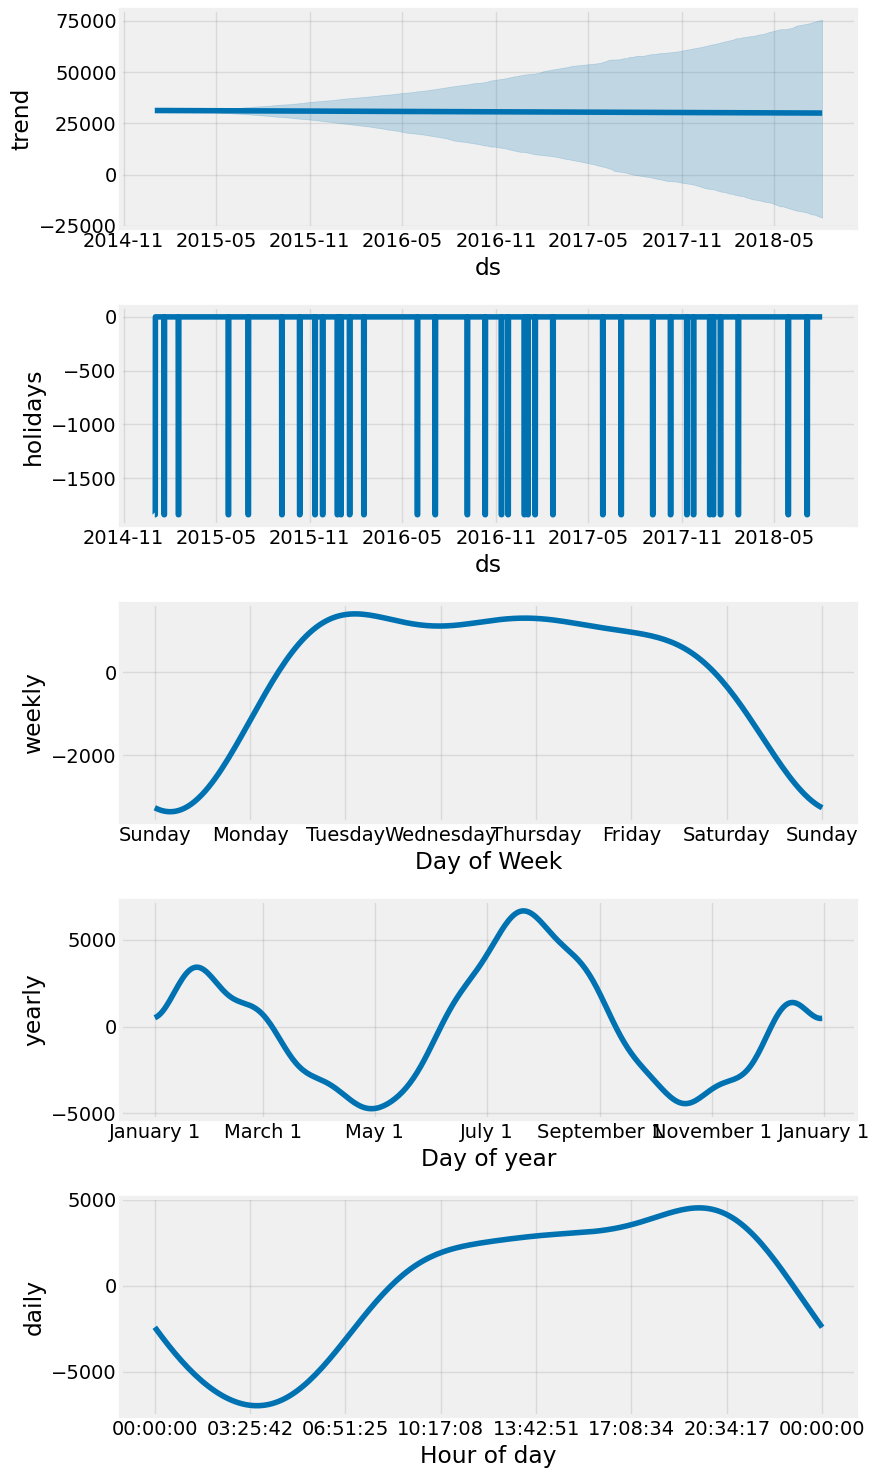

In [94]:
#Plot model components
fig=prophet_model.plot_components(prophet_fcst)

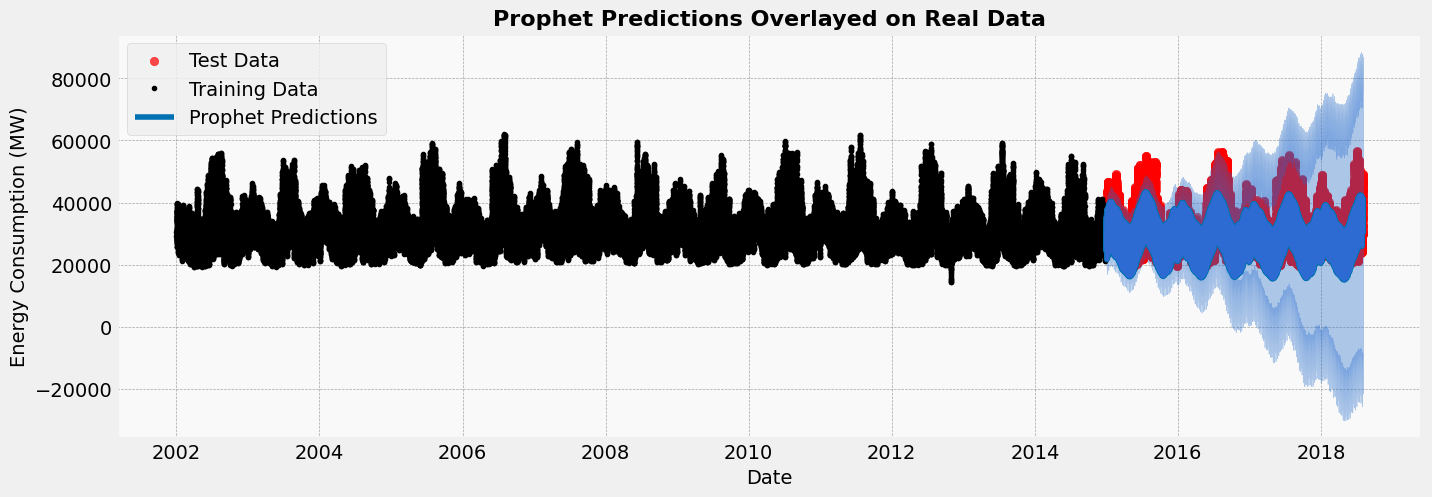

In [95]:
#Set up plot
f,ax=plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)

# actual plot of test data
ax.scatter(test.index,test['PJME_MW'],color='red',alpha=0.7,label='Real Data')

fig=prophet_model.plot(prophet_fcst,ax=ax,plot_cap=False)

# plot Prophet forecasts
ax.plot(prophet_fcst['ds'],prophet_fcst['yhat'],color='royalblue',linewidth=2.5,alpha=0.7,label='Prophet Predictions')
ax.fill_between(prophet_fcst['ds'],prophet_fcst['yhat_lower'],prophet_fcst['yhat_upper'],color='royalblue',alpha=0.2)

ax.set_title('Prophet Predictions Overlayed on Real Data',fontsize=16,fontweight='bold')
ax.set_xlabel('Date',fontsize=14)
ax.set_ylabel('Energy Consumption (MW)',fontsize=14)
plt.grid(True,linestyle='--',linewidth=0.5,alpha=0.7)
ax.set_facecolor('#f9f9f9')  # Light background color for the plot area
plt.legend(['Test Data','Training Data','Prophet Predictions'],fontsize='medium',loc='upper left')

plt.show()

In [96]:
#FBProphet Error metrics


prophet_MAE=mean_absolute_error(test['PJME_MW'],prophet_fcst['yhat'])
print(f'Mean Absolute Error Score : {prophet_MAE:0.2f}')

Mean Absolute Error Score : 3103.95


In [97]:
prophet_rmse=sqrt(mean_squared_error(test['PJME_MW'],prophet_fcst['yhat']))
print(f'RMSE Score on : {prophet_rmse:0.2f}')

RMSE Score on : 4126.77


In [98]:
prophet_MAPE=mape(test['PJME_MW'],prophet_fcst['yhat'])
print(f'Mean Absolute Percent Error Score : {prophet_MAPE:0.2f}')

Mean Absolute Percent Error Score : 9.61
